In [67]:
import tensorflow as tf
import json
import matplotlib.image as mpimg
import numpy as np
import os
from collections import defaultdict
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import heapq

import operator

from sklearn import metrics
from sklearn.metrics import roc_auc_score

from tensorflow.contrib.tensorboard.plugins import projector

%matplotlib inline

print("running TensorFlow version {}".format(tf.__version__))

running TensorFlow version 1.9.0


In [68]:
RANDOM_SEED = 42
#SUBSET = "golden_src"

LOG_ROOT = '../../data/'

RUN_NAME = 'vae/vae_016'
SUMMARY_DIR = os.path.join(LOG_ROOT, 'logs', RUN_NAME)

EXPT_NAME = 'expt_016'
DATA_ROOT = '/var/data/processed'
ORIGINAL_DATA_ROOT = '/var/data/original'

EXPT_DIR = os.path.join(DATA_ROOT, EXPT_NAME, 'data')
TFRECORDS_DIR = os.path.join(EXPT_DIR, 'tfrecords')
EMBEDDINGS_DIR = os.path.join(EXPT_DIR, 'embeddings')
GOLDEN_EMBEDDINGS_DIR = os.path.join(EXPT_DIR, 'golden_embeddings')
ENCODED_IMAGES_DIR =  os.path.join(EXPT_DIR, 'images')
ORIGINAL_IMAGES_DIR = os.path.join(ORIGINAL_DATA_ROOT, 'data', 'images')
ORIGINAL_JSONS_DIR = os.path.join(ORIGINAL_DATA_ROOT, 'labels')


In [ ]:
#get validation and test sets

validate_docs = []
test_docs = []
json_files = [pos_json for pos_json in os.listdir(EMBEDDINGS_DIR) if pos_json.endswith('.json')]
i = 0
for file in json_files:
    path = os.path.join(EMBEDDINGS_DIR, file)
    with open(path) as f:
        doc = json.load(f)
        if (doc['subset'] == 'validate'):
            validate_docs.append(doc)
        elif (doc['subset'] == 'test'):
            test_docs.append(doc)
        i += 1
        if(i%1000 == 0):
            print(i, end =" ")
            


In [58]:
#get golden sets for source and radiologist

golden_src_docs = []
golden_dr_docs = []

golden_json_files = [pos_json for pos_json in os.listdir(GOLDEN_EMBEDDINGS_DIR) if pos_json.endswith('.json')]

i = 0
for file in golden_json_files:
    path = os.path.join(GOLDEN_EMBEDDINGS_DIR, file)
    with open(path) as f:
        doc = json.load(f)
        if (doc['subset'] == 'golden_src'):
            golden_src_docs.append(doc)
        elif (doc['subset'] == 'golden_dr'):
            golden_dr_docs.append(doc)


# Examine images

## AU_ROC

In [70]:
import math

def sigmoid(lst):
    result = []
    for item in lst:
        
        sig = 1 / (1 + math.exp(-item))
        #sig = round(sig)
        result.append(sig)
        
    return result

In [71]:
aucs = []
prob = np.array(prob)
gt = np.array(gt)

for ii in range(gt.shape[1]):
    auc = roc_auc_score(np.array(gt[:, ii]), np.array(prob[:,ii]))
    aucs.append(auc)


In [72]:
print(aucs)
"total = {}".format(auc)

[0.6228384529393831, 0.7035963258129585, 0.6622514928781097, 0.7410830948625622, 0.6881331133222995, 0.601719033714803, 0.6974668847641191, 0.7495225468377607, 0.5712492664797548, 0.5744994994132042, 0.6070614751692065, 0.6234913416127339, 0.5779532440970311, 0.6398422038738713]


'total = 0.6398422038738713'

In [ ]:
print(aucs)
"total = {}".format(auc)

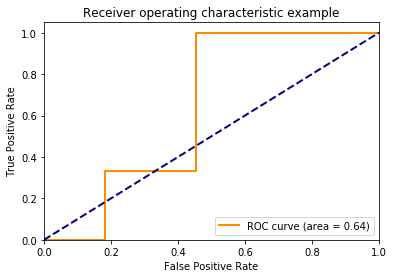

In [59]:
#inputs are binary vector of size 14 for labels and probability vector of size for pred_labels 

def roc_curve(labels, pred_labels):
    
    pred_labels = sigmoid(pred_labels)
    x,y,_ = roc_curve(labels, pred_labels)
    roc_auc = auc(x, y)
    plt.figure()
    lw = 2
    plt.plot(x, y, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [5]:
## Define label keys
LABEL_KEYS = [
    "Atelectasis",
    "Cardiomegaly",
    "Consolidation",
    "Edema",
    "Effusion",
    "Emphysema",
    "Fibrosis",
    "Hernia",
    "Infiltration",
    "Mass",
    "Nodule",
    "Pleural_Thickening",
    "Pneumonia",
    "Pneumothorax",
]

nb_label_keys = len(LABEL_KEYS)
label_keys_by_id = LABEL_KEYS
ids_by_label_key = OrderedDict([(k,v) for k, v in enumerate(label_keys_by_id)])



In [126]:
def cal_auroc(docs):

    label2score = {key: list([]) for key in LABEL_KEYS}
    count = {key: 0 for key in LABEL_KEYS}
    total_score = []
    
    for doc in docs:
        score = roc_auc_score(doc['labels'], sigmoid(doc['pred_labels']))
        for i,l in enumerate(doc['labels']):
            if(l == 1):
                label = ids_by_label_key[i]
                label2score[label].append(score)
                total_score.append(score)
                count[label] +=1
                
    return label2score, count, total_score
    '''for k in label2score:
        print("{:<20s}  {}".format(k,np.mean(label2score[k])))
    print("")
    print("{:<20s}  {}".format("TOTAL",np.mean(total_score)))'''

In [10]:
def cal_auroc(docs):

    category2labels = {key: list([]) for key in LABEL_KEYS}
    category2pred_labels = {key: list([]) for key in LABEL_KEYS}
    count = {key: 0 for key in LABEL_KEYS}
    total_score = []
    labels = []
    pred_labels = []
    for doc in docs:
        for i,l in enumerate(doc['labels']):
            if(doc['labels'][i] == 1):
                label = ids_by_label_key[i]
                category2labels[label].append(doc['labels'])
                category2pred_labels[label].append(doc['pred_labels'])
        
            elif(doc['pred_labels'][i] == 1):
                label = ids_by_label_key[i]
                category2labels[label].append(doc['labels'])
                category2pred_labels[label].append(doc['pred_labels'])
        
        labels.append(doc['labels'])
        pred_labels.append(doc['pred_labels'])
    
    #score = roc_auc_score(np.array(labels), np.array(pred_labels),average='micro')
    return category2labels, category2pred_labels
    

In [11]:
#"Results for expt_10 on validation data. classifier with removed no finding + weighting more on label 1
# + regularization 2 (CE) = 0.1"

val_category2labels, val_category2pred_labels = cal_auroc(validate_docs)

for k in val_category2labels:
    print("{:<20s}  {}".format(k,roc_auc_score(np.array(val_category2labels[k]), np.array(val_category2pred_labels[k]), average='micro')))
print("")
#print("{:<20s}  {}".format("TOTAL",np.mean(val_total_score)))

Atelectasis           0.8408167189313248
Cardiomegaly          0.6244322256753526
Consolidation         0.7346925030832744
Edema                 0.6178103519645013
Effusion              0.8377162007064203
Emphysema             0.5642486261398318
Fibrosis              0.4984956708796676
Hernia                0.2083941352234035
Infiltration          0.8806749154688329
Mass                  0.731914005426842
Nodule                0.7613478906203235
Pleural_Thickening    0.6187339559386974
Pneumonia             0.4891986070710871
Pneumothorax          0.6733184057321989



In [88]:
import numpy as np
from sklearn.metrics import roc_auc_score
y_true = np.array([[0, 0, 0, 0],[0, 1, 1, 1],[0, 1, 1, 1]])
y_pred = np.array([[0.1, 0.4, 0.35, 0.8],[0.1, 0.2, 0.75, 0.8],[0.1, 0.2, 0.75, 0.8]])
print(y_pred.dtype)
roc_auc_score(y_true, y_pred, average='samples')



int64


1.0

In [ ]:
score = []
for i,y in enumerate(y_true):
    score.append(roc_auc_score(y_true[i], y_scores[i]))
print(score)

In [6]:
#"Results for expt_10 on validation data. classifier with removed no finding + weighting more on label 1
# + regularization 2 (CE) = 0.1"

val_label2score, val_count, val_total_score = cal_auroc(validate_docs)

for k in val_label2score:
    print("{:<20s}  {}".format(k,np.mean(val_label2score[k])))
print("")
print("{:<20s}  {}".format("TOTAL",np.mean(val_total_score)))

NameError: name 'LABEL_KEYS' is not defined

In [112]:
#results for expt_10 on validation data. classifier with removed no finding + weighting more on label 1 
# + regularization 2 (CE) = 0.5
for k in tag2scores:
    print("{:<20s}  {}".format(k,np.mean(tag2scores[k])))

NameError: name 'tag2scores' is not defined

In [39]:
#"Results for expt_10 on golden_src data. classifier with removed no finding + weighting more on label 1
# + regularization 2 (CE) = 0.1"

golden_src_label2score, golden_src_count, golden_src_total_score = cal_auroc(golden_src_docs)

for k in golden_src_label2score:
    print("{:<20s}  {}".format(k,np.mean(golden_src_label2score[k])))
print("")
print("{:<20s}  {}".format("TOTAL",np.mean(golden_src_total_score)))

Atelectasis           0.8480769230769233
Cardiomegaly          0.46153846153846156
Consolidation         0.84375
Edema                 0.4615384615384615
Effusion              0.8811605061605061
Emphysema             0.43076923076923074
Fibrosis              0.1923076923076923
Hernia                0.0
Infiltration          0.9468864468864469
Mass                  0.8044871794871794
Nodule                0.578046953046953
Pleural_Thickening    0.686698717948718
Pneumonia             nan
Pneumothorax          0.5881118881118881

TOTAL                 0.7331330641189793


/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [61]:
#"Results for expt_10 on golden_dr data. classifier with removed no finding + weighting more on label 1
# + regularization 2 (CE) = 0.1"

golden_dr_label2score, golden_dr_count, golden_dr_total_score = cal_auroc(golden_dr_docs)

for k in golden_dr_label2score:
    print("{:<20s}  {}".format(k,np.mean(golden_dr_label2score[k])))
print("")
print("{:<20s}  {}".format("TOTAL",np.mean(golden_dr_total_score)))

Atelectasis           0.751118881118881
Cardiomegaly          0.48946386946386944
Consolidation         0.7758912655971478
Edema                 0.535916860916861
Effusion              0.7679587653725585
Emphysema             nan
Fibrosis              0.40466200466200464
Hernia                0.4409090909090909
Infiltration          0.8631944444444445
Mass                  0.744014319014319
Nodule                0.725
Pleural_Thickening    0.7072727272727273
Pneumonia             0.7250000000000001
Pneumothorax          0.7097125097125098

TOTAL                 0.70652289544907


/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [59]:
print(count)

{'Atelectasis': 9287, 'Cardiomegaly': 2240, 'Consolidation': 3788, 'Edema': 1880, 'Effusion': 10850, 'Emphysema': 2027, 'Fibrosis': 1314, 'Hernia': 183, 'Infiltration': 16046, 'Mass': 4662, 'Nodule': 5042, 'Pleural_Thickening': 2737, 'Pneumonia': 1111, 'Pneumothorax': 4316}


## F1 Score

In [84]:
for doc in val_documents:
    f1_score = metrics.f1_score(doc['labels'], sigmoid(doc['pred_labels']), average='weighted')
    for i,l in enumerate(doc['labels']):
        if(l == 1):
            label = ids_by_label_key[i]
            tag2scores[label].append(score)
            count[label] +=1


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [85]:
#results for expt_10 on validation data. classifier with removed no finding + weighting more on label 1 
# + regularization 2 (CE) = 0.1

for k in tag2scores:
    print("{:<20s}  {}".format(k,np.mean(tag2scores[k])))

Atelectasis           0.8709901533607588
Cardiomegaly          0.6635715868025428
Consolidation         0.7656593448090425
Edema                 0.6779740183469267
Effusion              0.8793934129475763
Emphysema             0.5787352325159423
Fibrosis              0.5403393921715622
Hernia                0.3407015881314947
Infiltration          0.9267484321213368
Mass                  0.7693612832085148
Nodule                0.8012287132698942
Pleural_Thickening    0.6470131942032211
Pneumonia             0.5579650339143322
Pneumothorax          0.7203177838038133


In [79]:
dash = '-' * 120

print("Radiologist{:<57} Source{:<20}"
          .format("",
                  "",
                 ""))
print(dash + "\n")

for dr_doc in golden_src_docs:
    pred_labels = sigmoid(dr_doc['pred_labels'])
    print(pred_labels, end = "               ")
    print(dr_doc['labels'])
    print("")

Radiologist                                                          Source                    
------------------------------------------------------------------------------------------------------------------------

[1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1]               [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

[1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]               [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

[1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0]               [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

[1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1]               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]

[1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0]               [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

[1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1]               [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

[1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0]               [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]

[1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1]               [0, 0, 0, 0, 0, 0,